To determine which non-demographic trip-level characteristics we should stratify by, we want to do some high level clustering.

we already have clustering based on demographics (which corresponds to the demographic stratification) and can show that the argmax replaced mode is not the same

we should now try two clusterings:
- based on trip summaries
    - % of trips in each primary sensed mode
    - number of trips
    - % of distance in each primary sensed mode
    - most common start time
    - most common end time

we can see whether the replaced mode argmax is now consistent in each cluster

- cluster based on the replaced mode distributions. features are:
        - % of trips with x replaced mode for x in set of unique replaced modes (filtered to top 75%)
        - distance of trips with x replaced mode for x in set of unique replaced modes (filtered to top 75%)

see how the demographics and trip summaries vary per cluster and see if there is a strong correlation between certain characteristics and being in the same cluster.


- Chart 1 will visualize the clustering with trip-summary features
- Chart 2 will visualize the clustering with replaced mode features.

Note that clustering is unsupervised and does not have a target variable.

For chart 1, for $n$ users, our input matrix will be $O(n \times 15)$ since there are ~ 6 sensed modes. After the clustering, we will check the replaced mode argmax distribution in each cluster.

For chart 2, for $n$ users where the 75th percentile of the replaced modes has modes, our input matrix will be $O(n \times 2 \times r)$. After the clustering, we will check the distribution of demographics and trip characteristics in each cluster.

In [30]:
import pandas as pd


df = pd.read_csv('../data/filtered_data/preprocessed_data_Stage_database.csv')
df.drop_duplicates(inplace=True)
display(df.target.value_counts())

9    72866
2    18633
5    13834
3     9455
8     7908
1     6539
4     1630
7     1469
6      189
Name: target, dtype: int64

In [1]:
import pandas as pd
import numpy as np
import random
import os
import itertools
import pickle
import ast
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List, Dict, Union
from pandas.api.types import is_numeric_dtype
from sklearn.cluster import DBSCAN, KMeans
from collections import Counter

pd.set_option('display.max_columns', None)

%matplotlib inline

SEED = 13210

np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Data is located at
CURRENT_DB = 'ride2own'

df = pd.read_csv('../data/filtered_data/preprocessed_data_openpath_prod_ride2own.csv')

In [3]:
df.target.value_counts()

9    800
4     33
8      6
7      5
2      1
1      1
3      1
5      1
Name: target, dtype: int64

In [4]:
df.rename(
    columns={'end_local_dt_hour': 'end:hour', 'start_local_dt_hour': 'start:hour', 'replaced_mode': 'target'}, 
    inplace=True
)

In [5]:
TARGETS = ['p_micro', 'no_trip', 's_car', 'transit', 'car', 's_micro', 'ridehail', 'walk', 'unknown']
MAP = {ix+1: t for (ix, t) in enumerate(TARGETS)}
TARGET_MAP = {v:k for k, v in MAP.items()}

In [6]:
df.replace({'target': TARGET_MAP}, inplace=True)

In [7]:
# % of trips per mode.
trip_percents = df.groupby(['user_id'])['section_mode_argmax'].apply(lambda x: x.value_counts(normalize=True)).unstack(level=-1)
trip_percents.fillna(0., inplace=True)

trip_percents.columns = ['coverage_'+x for x in trip_percents.columns]

In [8]:
n_trips = pd.DataFrame(df.groupby('user_id').size(), columns=['n_trips'])

In [9]:
most_common_start = df.groupby('user_id')['start:hour'].apply(lambda x: x.value_counts().idxmax())

In [10]:
most_common_end = df.groupby('user_id')['end:hour'].apply(lambda x: x.value_counts().idxmax())

In [11]:
# % of distance in each primary sensed mode.
total_distance = df.groupby(['user_id', 'section_mode_argmax'])['section_distance_argmax'].sum().unstack(level=-1)
total_distance = total_distance.div(total_distance.sum(axis=1), axis=0)
total_distance.fillna(0., inplace=True)
total_distance.columns = ['pct_distance_' + x for x in total_distance.columns]

In [12]:
figure1_df = trip_percents.merge(right=total_distance, left_index=True, right_index=True).merge(
   right=n_trips, left_index=True, right_index=True
).merge(
   right=most_common_start, left_index=True, right_index=True
).merge(right=most_common_end, left_index=True, right_index=True)

In [13]:
# Normalize the last three columns.

def min_max_normalize(col: pd.Series):
    _max, _min = col.max(), col.min()
    return pd.Series((col - _min)/(_max - _min))

figure1_df['n_trips'] = min_max_normalize(figure1_df['n_trips'])
figure1_df['start:hour'] = np.sin(figure1_df['start:hour'].values)
figure1_df['end:hour'] = np.sin(figure1_df['end:hour'].values)

In [14]:
figure1_df.head()

,coverage_bicycling,coverage_car,coverage_transit,coverage_unknown,coverage_walking,pct_distance_bicycling,pct_distance_car,pct_distance_transit,pct_distance_unknown,pct_distance_walking,n_trips,start:hour,end:hour
user_id,,,,,,,,,,,,,
258a8119-a5c2-4d38-875d-a9a9f7ed2d7d,0.166667,0.333333,0.166667,0.166667,0.166667,0.172218,0.668293,0.017667,0.134188,0.007634,0.008219,-0.287903,-0.287903
7ac8a16d-bafe-4bef-a5b5-43b64beb97a6,0.033113,0.443709,0.119205,0.013245,0.390728,0.023119,0.862170,0.086055,0.005839,0.022817,0.819178,0.650288,0.420167
87e12281-655e-4b7f-9dce-67b42217a5e8,0.300000,0.233333,0.033333,0.033333,0.400000,0.277527,0.515470,0.037176,0.037151,0.132676,0.073973,-0.544021,-0.544021
bc08c318-5a56-4e11-9f69-9c48468b7571,0.067935,0.739130,0.048913,0.027174,0.116848,0.038010,0.914976,0.022974,0.009626,0.014414,1.000000,0.656987,-0.961397
be2a3c5c-1db0-4736-8304-a1c705da4cd6,0.009174,0.220183,0.055046,0.073394,0.642202,0.012170,0.416293,0.092856,0.080060,0.398620,0.290411,-0.287903,0.656987


In [15]:
epsilons = np.linspace(1e-3, 1., 1000)

best_eps = -np.inf
best_score = -np.inf

for eps in epsilons:
    model = DBSCAN(eps=eps).fit(figure1_df)
    
    if len(np.unique(model.labels_)) < 2:
        continue
    
    score = silhouette_score(figure1_df, model.labels_)
    if score > best_score:
        best_eps = eps
        best_score = score

print(best_eps)

-inf


In [24]:
'''
AlLCEO: eps=0.542
durham: eps=0.661
masscec: eps=0.64
'''

clustering = DBSCAN(eps=0.8).fit(figure1_df)

print(Counter(clustering.labels_))

Counter({-1: 7})


7 users in cluster -1


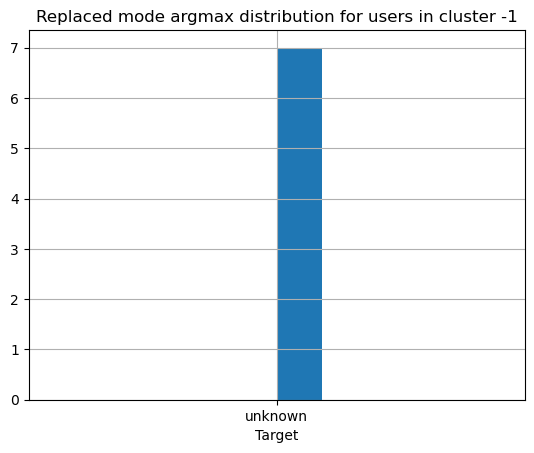

In [25]:
# After clustering, we would like to see what the replaced mode argmax distribution in each cluster is.

labels = clustering.labels_

for cix in np.unique(labels):
    cluster_users = figure1_df.iloc[labels == cix,:].index
    
    print(f"{len(cluster_users)} users in cluster {cix}")
    
    # Now, for each user, look at the actual data and determine the replaced mode argmax distribution.
    sub_df = df.loc[df.user_id.isin(cluster_users), :].reset_index(drop=True)
    
    sub_df['target'] =  sub_df['target'].apply(lambda x: MAP[x])
    
    rm_argmax = sub_df.groupby('user_id')['target'].apply(lambda x: x.value_counts().idxmax())
    fig, ax = plt.subplots()
    rm_argmax.hist(ax=ax)
    ax.set_title(f"Replaced mode argmax distribution for users in cluster {cix}")
    ax.set_xlabel("Target")
    
    plt.savefig(f'./plots_for_paper/{CURRENT_DB}__FIG1_cluster_{cix}_target_dist.png', dpi=300)
    
    plt.show()

In [ ]:
user_target_pct = pd.DataFrame()

# For every user, compute the replaced mode distribution.
for user_id, user_data in df.groupby('user_id'):
    
    target_distribution = user_data['target'].value_counts(normalize=True)
    target_distribution.rename(index=MAP, inplace=True)
    user_target_pct = pd.concat([user_target_pct, target_distribution.to_frame(user_id).T])

In [ ]:
user_target_pct.columns = ['pct_trips_' + str(x) for x in user_target_pct.columns]

In [ ]:
target_distance = pd.DataFrame()

# For every user, compute the replaced mode distribution.
for user_id, user_data in df.groupby('user_id'):
    
    # total_distance = user_data['distance'].sum()
    distance_per_target = user_data.groupby('target')['section_distance_argmax'].sum()
    distance_per_target.rename(index=MAP, inplace=True)
    row = distance_per_target.to_frame(user_id).T
    target_distance = pd.concat([target_distance, row])
    
target_distance.columns = ['distance_' + str(x) for x in target_distance.columns]

In [ ]:
target_duration = df.groupby(['user_id', 'target'])['section_duration_argmax'].sum().unstack()
target_duration.rename(columns=MAP, inplace=True)
target_duration.fillna(0., inplace=True)
target_duration.columns = ['duration_' + str(x) for x in target_duration.columns]

In [ ]:
target_df = user_target_pct.merge(right=target_distance, left_index=True, right_index=True).merge(
    right=target_duration, left_index=True, right_index=True
)

target_df.fillna(0., inplace=True)

target_df = pd.DataFrame(
    MinMaxScaler().fit_transform(target_df),
    columns=target_df.columns,
    index=target_df.index
)

display(target_df)

In [ ]:
epsilons = np.linspace(5e-3, 1., 1500)
best_score = -np.inf
best_eps = None
best_n = None
# alpha = 0.7
beta = 0.05

for eps in epsilons:
    for n in range(2, 30):
        labels = DBSCAN(eps=eps, min_samples=n).fit(target_df).labels_
    
        n_unique = np.unique(labels)
        n_outliers = len(labels[labels == -1])
        
        if n_outliers == len(labels) or len(n_unique) < 2:
            continue
    
        # Encourage more clustering and discourage more outliers.
        score = silhouette_score(target_df, labels) + (len(labels) - n_outliers)/n_outliers
        
        if score > best_score:
            best_score = score
            best_eps = eps
            best_n = n

print(f"{best_score=}, {best_n=}, {best_eps=}")

In [ ]:
# 0.35 is a good value

'''
allCEO = DBSCAN(eps=0.52, min_samples=2)
durham: DBSCAN(eps=best_eps, min_samples=2)
masscec: min_samples=2, eps=0.986724482988659
'''

cl2 = DBSCAN(eps=best_eps, min_samples=2).fit(target_df)
# cl2 = KMeans(n_clusters=5).fit(target_df)

Counter(cl2.labels_)

In [ ]:
from sklearn.decomposition import PCA

tsfm = PCA(n_components=2).fit_transform(target_df)

fig, ax = plt.subplots()
sns.scatterplot(x=tsfm[:,0], y=tsfm[:,1], c=cl2.labels_)
ax.set(xlabel='Latent Dim 0', ylabel='Latent Dim 1')
plt.savefig(f'./plots_for_paper/{CURRENT_DB}__Fig2__PCA_w_colors.png', dpi=300)
plt.show()

In [ ]:
print(df.columns.tolist())

In [ ]:
# Per-cluster users.
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier


demographic_cols = {
    'Stage_database': [
        'has_drivers_license', 'is_student', 'is_paid', 
        'income_category', 'n_residence_members', 'n_residents_u18', 'n_residents_with_license', 
        'n_motor_vehicles', 'has_medical_condition', 'ft_job', 'multiple_jobs', 
        'n_working_residents', "highest_education_Bachelor's degree", 
        'highest_education_Graduate degree or professional degree', 
        'highest_education_High school graduate or GED', 'highest_education_Less than a high school graduate', 
        'highest_education_Prefer not to say', 'highest_education_Some college or associates degree', 
        'primary_job_description_Clerical or administrative support', 'primary_job_description_Custodial', 
        'primary_job_description_Education', 'primary_job_description_Food service', 
        'primary_job_description_Linecook', 
        'primary_job_description_Manufacturing, construction, maintenance, or farming', 
        'primary_job_description_Medical/healthcare', 'primary_job_description_Non-profit program manager', 
        'primary_job_description_Other', 'primary_job_description_Professional, managerial, or technical', 
        'primary_job_description_Sales or service', 'primary_job_description_Self employed', 
        'primary_job_description_food service', 'gender_Man', 'gender_Nonbinary/genderqueer/genderfluid', 
        'gender_Prefer not to say', 'gender_Woman', 'gender_Woman;Nonbinary/genderqueer/genderfluid', 
        'av_transit', 'av_no_trip', 'av_p_micro', 'av_s_micro', 'av_ridehail', 'av_unknown', 'av_walk', 'av_car', 
        'av_s_car'
    ] + [c for c in df.columns if 'age' in c],
    'durham': [
        'is_student', 'is_paid', 'has_drivers_license', 
        'n_residents_u18', 'n_residence_members', 'income_category',
        'n_residents_with_license', 'n_working_residents', 'n_motor_vehicles', 'has_medical_condition', 
        'ft_job', 'multiple_jobs', 'highest_education_bachelor_s_degree', 
        'highest_education_graduate_degree_or_professional_degree', 
        'highest_education_high_school_graduate_or_ged', 'highest_education_less_than_a_high_school_graduate', 
        'highest_education_some_college_or_associates_degree', 
        'primary_job_description_Clerical or administrative support', 
        'primary_job_description_Manufacturing, construction, maintenance, or farming', 
        'primary_job_description_Other', 'primary_job_description_Professional, Manegerial, or Technical', 
        'primary_job_description_Sales or service', 'gender_man', 
        'gender_non_binary_genderqueer_gender_non_confor', 'gender_woman', 
        'av_walk', 'av_unknown', 'av_no_trip', 'av_p_micro', 'av_transit', 'av_car', 'av_ridehail', 
        'av_s_micro', 'av_s_car'
    ] + [c for c in df.columns if 'age' in c],
    'masscec': [
        'is_student', 'is_paid', 'has_drivers_license', 'n_residents_u18', 'n_residence_members', 
        'income_category', 'n_residents_with_license', 'n_working_residents', 'n_motor_vehicles', 
        'has_medical_condition', 'ft_job', 'multiple_jobs', 'highest_education_bachelor_s_degree', 
        'highest_education_graduate_degree_or_professional_degree', 
        'highest_education_high_school_graduate_or_ged', 'highest_education_less_than_a_high_school_graduate', 
        'highest_education_prefer_not_to_say', 'highest_education_some_college_or_associates_degree', 
        'primary_job_description_Clerical or administrative support', 
        'primary_job_description_Manufacturing, construction, maintenance, or farming', 
        'primary_job_description_Other', 'primary_job_description_Prefer not to say', 
        'primary_job_description_Professional, Manegerial, or Technical', 
        'primary_job_description_Sales or service', 'gender_man', 'gender_prefer_not_to_say', 'gender_woman', 
        'av_p_micro', 'av_s_car', 'av_s_micro', 'av_transit', 'av_car', 'av_no_trip', 'av_unknown', 
        'av_ridehail', 'av_walk'
    ] + [c for c in df.columns if 'age' in c],
}


cluster_labels = cl2.labels_
demographics = df.groupby('user_id').first()[demographic_cols[CURRENT_DB]]
demographics = demographics.loc[target_df.index, :]

In [ ]:
### DEMOGRAPHICS

def entropy(x):
    # Compute bincount, normalize over the entire size. Gives us probabilities.
    p = np.unique(x, return_counts=True)[1]/len(x)
    # Compute the enropy usnig the probabilities.
    return -np.sum(p * np.log2(p))

def preprocess_demo_data(df: pd.DataFrame):
    return df


within_cluster_homogeneity = dict()
other_cluster_homogeneity = dict()
labels = cl2.labels_

for cix in np.unique(labels):
    within_cluster_homogeneity[cix] = dict()
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)
    
    for col in processed.columns:
        # Numeric/ordinal values. Use std. to measure homogeneity.
        if col in [
            'n_residence_members', 'n_residents_u18', 'n_working_residents', 'n_motor_vehicles',
            'n_residents_with_license', 'income_category'
        ]:
            within_cluster_homogeneity[cix][col] = processed[col].std()
        else:
            within_cluster_homogeneity[cix][col] = entropy(processed[col])

# Compute average homogeneity across other clusters.
for cix in within_cluster_homogeneity.keys():
    other_cluster_homogeneity[cix] = dict()
    other_clusters = set(within_cluster_homogeneity.keys()) - set([cix])
    for feature in within_cluster_homogeneity[cix].keys():
        homogeneity_in_others = [within_cluster_homogeneity[x][feature] for x in other_clusters]
        other_cluster_homogeneity[cix][feature] = np.mean(homogeneity_in_others)

        
# Compute contrastive homogeneity
# CH = homogeneity within cluster / average homogeneity across other clusters
for cix in within_cluster_homogeneity.keys():
    ch_scores = list()
    print(f"For cluster {cix}:")
    for feature in within_cluster_homogeneity[cix].keys():
        feature_ch = within_cluster_homogeneity[cix][feature]/(other_cluster_homogeneity[cix][feature] + 1e-6)
        ch_scores.append((feature, feature_ch))
    
    ch_df = pd.DataFrame(ch_scores, columns=['feature', 'ch']).sort_values(by=['ch']).head(4)
    
    # Display actual values.
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)
    
    display(ch_df)
    print()
    filtered = processed.loc[:, processed.columns.isin(ch_df.feature)][ch_df.feature]
    filtered_features = ch_df.feature.tolist()
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    for i, a in enumerate(ax.flatten()):
        sns.histplot(filtered[filtered_features[i]], ax=a, stat="percent")
    plt.tight_layout()
    plt.savefig(f"{CURRENT_DB}_{cix}_Demographic_consistency.png", dpi=300)
    plt.show()
    print()

In [ ]:
from scipy.stats import iqr

def get_trip_summary_df(users, df):
    '''
    1. df = a huge dataframe of user-trips. Each row is a trip.
    2. every trip is divided into sections: [walk, transit, walk]
    3. Each section has a corresponding distance and duration: [m1, m2, m3], [t1, t2, t3], [d1, d2, d3]
    4. What we are doing is only considering the mode, distance, and duration of the section with the largest distance
    '''
    
    costs = [c for c in df.columns if 'av_' in c]
    
    mode_coverage = df.groupby(['user_id', 'section_mode_argmax'])[
        ['section_duration_argmax', 'section_distance_argmax', 'mph'] + costs
    ].agg(['mean', 'median']).unstack()
    
    global_stats = df.groupby('user_id')[['duration', 'distance']].agg(
        ['mean', 'median']
    )

    mode_coverage.columns = mode_coverage.columns.map('_'.join)
    global_stats.columns = global_stats.columns.map('_'.join)
    
    # return mode_coverage
    return mode_coverage.merge(right=global_stats, left_index=True, right_index=True)

In [ ]:
## TRIP SUMMARIES

# Per-cluster users.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, mutual_info_classif

labels = cl2.labels_

def get_data(cix):
    users = target_df.iloc[labels == cix, :].index
    
    # Compute trip summaries.
    X = df.loc[df.user_id.isin(users), [
        'section_distance_argmax', 'duration', 'distance', 'section_mode_argmax',
        'section_duration_argmax', 'mph', 'target', 'user_id'
    ] + [c for c in df.columns if 'cost_' in c]].reset_index(drop=True)
    
    # Compute the target distribution and select the argmax.
    target_distribution = X.target.value_counts(ascending=False, normalize=True)
    target_distribution.rename(index=MAP, inplace=True)
    
    # Caution - this summary df has NaNs. Use nanstd() to compute nan-aware std.
    subset = get_trip_summary_df(users, X)
    
    norm_subset = pd.DataFrame(
        MinMaxScaler().fit_transform(subset),
        columns=subset.columns, index=subset.index
    )
    
    return norm_subset, target_distribution


in_cluster_homogeneity = dict()
out_cluster_homogeneity = dict()

for cluster_ix in np.unique(labels):
    in_cluster_homogeneity[cluster_ix] = dict()
    norm_subset, _ = get_data(cluster_ix)
    for feature in norm_subset.columns:
        in_cluster_homogeneity[cluster_ix][feature] = np.nanstd(norm_subset[feature])

for cix in in_cluster_homogeneity.keys():
    out_cluster_homogeneity[cix] = dict()
    oix = set(labels) - set([cix])
    for feature in norm_subset.columns:
        out_cluster_homogeneity[cix][feature] = np.nanmean([in_cluster_homogeneity[x].get(feature, np.nan) for x in oix])

# Now, compute the per-cluster homogeneity.
for cix in in_cluster_homogeneity.keys():
    ch = list()
    for feature in in_cluster_homogeneity[cix].keys():
        if feature in in_cluster_homogeneity[cix] and feature in out_cluster_homogeneity[cix]:
            ratio = in_cluster_homogeneity[cix][feature] / (out_cluster_homogeneity[cix][feature] + 1e-6)
        ch.append([feature, ratio])
    
    ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).head(4)
    data, target_dist = get_data(cix)
    
    features = ch_df.feature.tolist()
    
    print(f"For cluster {cix}:")
    display(target_dist)
    display(ch_df)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    for i, a in enumerate(ax.flatten()):
        sns.histplot(data[features[i]], ax=a, stat="percent")
    plt.tight_layout()
    plt.savefig(f"{CURRENT_DB}_{cix}_Trip_consistency.png", dpi=300)
    plt.show()
    print()
    
    print(50*'=')

## Now check the combined homogeneity score

In [ ]:
ic, oc = dict(), dict()

labels = cl2.labels_
TOP_K = 3


for cix in np.unique(labels):
    ic[cix] = dict()
    
    # Trip characteristics.
    norm_subset, _ = get_data(cix)
    for feature in norm_subset.columns:
        ic[cix][feature] = np.nanstd(norm_subset[feature])
    
    # Demographics.
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)
    
    for col in processed.columns:
        # Numeric/ordinal values. Use std. to measure homogeneity.
        if col in [
            'n_residence_members', 'n_residents_u18', 'n_working_residents', 'n_motor_vehicles',
            'n_residents_with_license', 'income_category'
        ]:
            ic[cix][col] = np.nanstd(processed[col])
        else:
            ic[cix][col] = entropy(processed[col])

for cix in ic.keys():
    oc[cix] = dict()
    oix = set(labels) - set([cix])
    for feature in ic[cix].keys():
        oc[cix][feature] = np.nanmean([ic[x].get(feature, np.nan) for x in oix])

per_cluster_most_homogeneous = dict()

# Now, compute the per-cluster homogeneity.
ax_ix = 0
for cix in ic.keys():

    print(f"For cluster {cix}:")

    # For each, cluster, we will have (TOP_K x n_clusters) figures.
    fig, ax = plt.subplots(nrows=TOP_K, ncols=len(ic.keys()), figsize=(12, 8))

    other_ix = set(ic.keys()) - set([cix])
    
    ch = list()
    for feature in ic[cix].keys():
        if feature in oc[cix]:
            ratio = ic[cix][feature] / (oc[cix][feature] + 1e-6)
        ch.append([feature, ratio])
    
    # Just the top k.
    ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).reset_index(drop=True).head(TOP_K)

    figure_data = dict()
    
    # Get the actual trip summary data.
    trip_summary_data, target_dist = get_data(cix)
    
    # Get the actual demographic data.
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)

    # Left-most subplot will be that of the current cluster's feature.
    for row_ix, row in ch_df.iterrows():
        if row.feature in trip_summary_data.columns:
            sns.histplot(trip_summary_data[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
        else:
            sns.histplot(processed[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
        ax[row_ix][0].set_xlabel(ax[row_ix][0].get_xlabel(), fontsize=8)
        ax[row_ix][0].set_ylim(0., 100.)

    offset_col_ix = 1
    ## Now, others.
    for oix in other_ix:
        # Get the actual trip summary data.
        other_summary_data, _ = get_data(oix)
        
        # Get the actual demographic data.
        users = target_df[labels == oix].index
        data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
        other_demo = preprocess_demo_data(data)

        for row_ix, row in ch_df.iterrows():
            if row.feature in other_summary_data.columns:
                sns.histplot(other_summary_data[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
            else:
                sns.histplot(other_demo[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
            ax[row_ix][offset_col_ix].set_xlabel(ax[row_ix][offset_col_ix].get_xlabel(), fontsize=8)
            ax[row_ix][offset_col_ix].set_ylim(0., 100.)
            
        offset_col_ix += 1
    
    plt.tight_layout()
    plt.savefig(f"./plots_for_paper/{CURRENT_DB}_cluster{cix}_combined_features.png", dpi=300)
    plt.show()
    print(50 * '=')

## Try a different clustering technique?

In [ ]:
from sklearn.cluster import AffinityPropagation

best_score = -np.inf
best_params = None

In [ ]:
cls = AffinityPropagation(random_state=13210).fit(target_df)
labels = cls.labels_

print(labels)

In [ ]:
center_embeddings = cls.cluster_centers_
centers_proj = PCA(n_components=2).fit_transform(center_embeddings)

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x=tsfm[:,0], y=tsfm[:,1], c=cls.labels_, ax=ax)
ax.scatter(x=centers_proj[:,0], y=centers_proj[:,1], marker='X', c='red', alpha=0.5)
ax.set(xlabel='Latent Dim 0', ylabel='Latent Dim 1')
# plt.legend([str(x) for x in ap_labels], loc='best')
plt.show()

In [ ]:
def get_data2(cix, labels):
    users = target_df.iloc[labels == cix, :].index
    
    # Compute trip summaries.
    X = df.loc[df.user_id.isin(users), [
        'section_distance_argmax', 'section_duration_argmax',
        'section_mode_argmax', 'distance',
        'duration', 'mph', 'user_id', 'target'
    ]]
    
    # Compute the target distribution and select the argmax.
    target_distribution = X.target.value_counts(ascending=False, normalize=True)
    target_distribution.rename(index=MAP, inplace=True)
    
    # Caution - this summary df has NaNs. Use nanstd() to compute nan-aware std.
    subset = get_trip_summary_df(users, X)
    
    norm_subset = pd.DataFrame(
        MinMaxScaler().fit_transform(subset),
        columns=subset.columns, index=subset.index
    )
    
    return norm_subset, target_distribution

In [ ]:
## Analaysis for this data.

ic, oc = dict(), dict()
labels = cls.labels_

for cix in np.unique(labels):
    users = target_df[labels == cix].index
    
    ic[cix] = dict()
    
     # Trip characteristics.
    norm_subset, _ = get_data2(cix, labels)
    for feature in norm_subset.columns:
        ic[cix][feature] = np.nanstd(norm_subset[feature])
    
    # Demographics.
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)
    
    for col in processed.columns:
        # Numeric/ordinal values. Use std. to measure homogeneity.
        if col == 'age' or col == 'income_category' or col == 'n_working_residents':
            ic[cix][col] = np.nanstd(processed[col])
        else:
            ic[cix][col] = entropy(processed[col])

for cix in ic.keys():
    oc[cix] = dict()
    oix = set(labels) - set([cix])
    for feature in ic[cix].keys():
        oc[cix][feature] = np.nanmean([ic[x].get(feature, np.nan) for x in oix])

# # Now, compute the per-cluster homogeneity.
# for cix in ic.keys():
    
#     users = users = target_df[labels == cix].index
#     norm_subset, target_dist = get_data(cix, labels)
#     data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
#     processed = preprocess_demo_data(data)
    
#     concat = processed.merge(norm_subset, left_index=True, right_index=True)
    
#     ch = list()
#     for feature in ic[cix].keys():
#         ratio = ic[cix][feature] / (oc[cix][feature] + 1e-6)
#         ch.append([feature, ratio])
    
#     ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).head(TOP_K).reset_index(drop=True)


# Now, compute the per-cluster homogeneity.
ax_ix = 0
for cix in ic.keys():

    print(f"For cluster {cix}:")

    # For each, cluster, we will have (TOP_K x n_clusters) figures.
    fig, ax = plt.subplots(nrows=5, ncols=len(ic.keys()), figsize=(12, 8))

    other_ix = set(ic.keys()) - set([cix])
    
    ch = list()
    for feature in ic[cix].keys():
        ratio = ic[cix][feature] / (oc[cix][feature] + 1e-6)
        ch.append([feature, ratio])
    
    # Just the top k.
    ch_df = pd.DataFrame(ch, columns=['feature', 'ch']).sort_values(by=['ch']).reset_index(drop=True).head(5)
    figure_data = dict()
    
    # Get the actual trip summary data.
    trip_summary_data, target_dist = get_data(cix)

    display(target_dist)
    
    # Get the actual demographic data.
    users = target_df[labels == cix].index
    data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
    processed = preprocess_demo_data(data)

    # Left-most subplot will be that of the current cluster's feature.
    for row_ix, row in ch_df.iterrows():
        if row.feature in trip_summary_data.columns:
            sns.histplot(trip_summary_data[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
        else:
            sns.histplot(processed[row.feature], ax=ax[row_ix][0], stat='percent').set_title("Current cluster")
        ax[row_ix][0].set_xlabel(ax[row_ix][0].get_xlabel(), fontsize=6)
        ax[row_ix][0].set_ylim(0., 100.)

    offset_col_ix = 1
    ## Now, others.
    for oix in other_ix:
        # Get the actual trip summary data.
        other_summary_data, _ = get_data(oix)
        
        # Get the actual demographic data.
        users = target_df[labels == oix].index
        data = demographics.loc[demographics.index.isin(users), :].reset_index(drop=True)
        other_demo = preprocess_demo_data(data)

        for row_ix, row in ch_df.iterrows():
            if row.feature in other_summary_data.columns:
                sns.histplot(other_summary_data[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
            else:
                sns.histplot(other_demo[row.feature], ax=ax[row_ix][offset_col_ix], stat='percent').set_title(f"Cluster {oix}")
            ax[row_ix][offset_col_ix].set_xlabel(ax[row_ix][offset_col_ix].get_xlabel(), fontsize=6)
            ax[row_ix][offset_col_ix].set_ylim(0., 100.)
            
        offset_col_ix += 1

    plt.tight_layout()
    plt.show()
    print(50 * '=')